# 事件研究法

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats


In [187]:
sns.set_palette("Set2")
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [188]:
events = ['2021-02-08','2021-03-24','2021-05-13']

In [189]:
p1 = "不含比特币的加密货币市值.xlsx"
p2 = "BTC-USD.xlsx"

In [190]:
df_index = pd.read_excel(p1)
df = pd.read_excel(p2)

In [191]:
df_index = df_index[['Date', 'pct_chg']].copy()
df_index.columns = ['trade_date', '数字货币市场收益率']

In [192]:
df = df[['Date', '收益率']].copy()
df.columns = ['trade_date', '比特币收益率']

In [193]:
df_final = df.merge(df_index, on='trade_date', how='left')

In [194]:
df_final

,trade_date,比特币收益率,数字货币市场收益率
0,2020-12-01,NaN,-0.012361
1,2020-12-02,-0.013501,-0.005496
2,2020-12-03,0.021956,0.022142
3,2020-12-04,-0.007389,-0.023353
4,2020-12-05,-0.012058,-0.019963
...,...,...,...
193,2021-06-12,-0.020798,-0.025634
194,2021-06-13,0.028019,0.027689
195,2021-06-14,0.072129,0.043749
196,2021-06-15,0.014556,0.010420


In [195]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  198 non-null    datetime64[ns]
 1   比特币收益率      197 non-null    float64       
 2   数字货币市场收益率   198 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 6.2 KB


In [196]:
df_final = df_final.dropna()

In [197]:
df_final = df_final.reset_index().drop("index", axis=1)

In [204]:
from sklearn.linear_model import LinearRegression
def get_OLS(X, y, pre_X):
    linear_m = LinearRegression().fit(X, y)
    r_2 = linear_m.score(X, y)
    print(f"构建模型，R2为{round(r_2*100, 2)}%")
    print(f"y = {round(linear_m.intercept_,3)} + {round(linear_m.coef_[0],3)}Rm ")
    return linear_m.predict(pre_X)

In [233]:
def get_data(event):
    print("事件日为: ", event)
    q, h = df_final[df_final['trade_date'] == event].index[0] - 10, df_final[df_final['trade_date'] == event].index[0] + 10
    target = df_final.loc[q:h].copy()
    estimate_df = df_final.loc[q-150:q]
    
    X = estimate_df[['数字货币市场收益率']]
    y = estimate_df['比特币收益率']
    predict_X = target[['数字货币市场收益率']]
    target['E(Rt)'] = get_OLS(X, y, predict_X)
    target['ARt'] = target['比特币收益率'] - target['E(Rt)']
    #对异常收益率进行t检验 判断是否显著异于0
    pop_mean = 0
    t,p_twoTail =stats.ttest_1samp(target['ARt'],pop_mean)
    p_oneTail = p_twoTail/2
    print("t=",t,"p_twoTail=",p_twoTail, "p_oneTail = ", p_oneTail)
    alpha = 0.05
    if (t<0 and p_oneTail < alpha):
        print("拒绝零假设，有统计显著，也就是事件带来异常收益")
    else:
        print("接受零假设，没有统计显著，也就是事件未带来异常收益")
    
    target['CARt'] =  target['ARt'].cumsum()
    print(target)
    return target



In [238]:
def main(e):
    for i in range(len(e)):
        a = get_data(e[i])
        j = i + 1
        a.to_excel('事件%s.xls' %j)
        a.set_index('trade_date')[['ARt', 'CARt']].plot(figsize=(13, 6))
        plt.ylim(-0.4,0.4)
        plt.xlabel('Event %s'%j)
        plt.ylabel('比特币收益率')
    

事件日为:  2021-02-08
构建模型，R2为48.9%
y = 0.003 + 0.784Rm 
t= 0.13310594640037923 p_twoTail= 0.8954397567516843 p_oneTail =  0.44771987837584215
接受零假设，没有统计显著，也就是事件未带来异常收益
   trade_date    比特币收益率  数字货币市场收益率     E(Rt)       ARt      CARt
58 2021-01-29  0.129448   0.058037  0.048328  0.081120  0.081120
59 2021-01-30 -0.039011  -0.000908  0.002088 -0.041098  0.040022
60 2021-01-31 -0.018110   0.004424  0.006270 -0.024381  0.015641
61 2021-02-01  0.006946   0.020088  0.018558 -0.011612  0.004029
62 2021-02-02  0.034659   0.043810  0.037168 -0.002508  0.001520
63 2021-02-03  0.049734   0.017214  0.016304  0.033430  0.034950
64 2021-02-04  0.026863   0.073631  0.060561 -0.033698  0.001252
65 2021-02-05 -0.000334   0.035219  0.030428 -0.030762 -0.029510
66 2021-02-06  0.053308   0.029619  0.026035  0.027273 -0.002237
67 2021-02-07 -0.024569  -0.028123 -0.019262 -0.005307 -0.007544
68 2021-02-08  0.089460   0.064157  0.053129  0.036331  0.028786
69 2021-02-09  0.100286   0.051320  0.043059  0.057227 

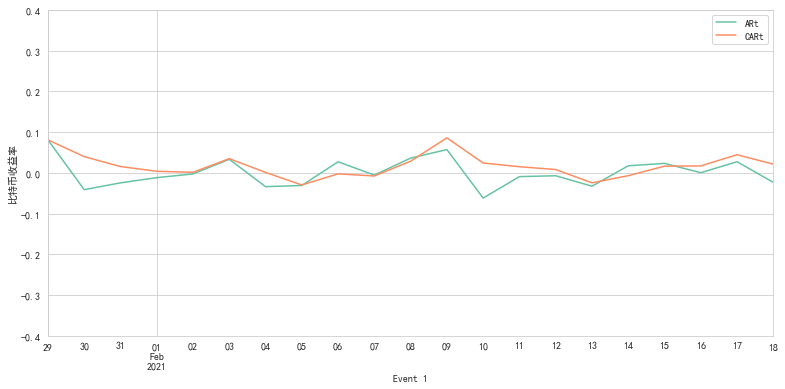

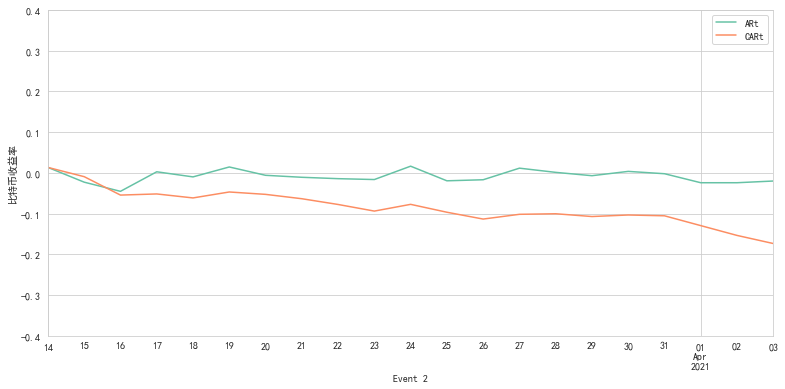

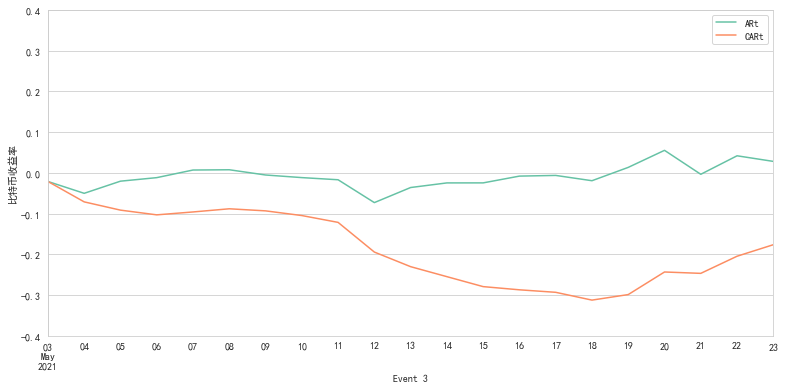

In [239]:
main(events)

In [209]:
a

,trade_date,比特币收益率,数字货币市场收益率,E(Rt),ARt,CARt
109,2021-03-21,-0.029794,-0.028005,-0.022730,-0.007064,-0.007064
110,2021-03-22,-0.017702,-0.007831,-0.006306,-0.011396,-0.018461
111,2021-03-23,-0.029735,-0.020724,-0.016803,-0.012932,-0.031392
112,2021-03-24,0.002925,-0.020860,-0.016913,0.019838,-0.011555
113,2021-03-25,-0.051667,-0.045239,-0.036760,-0.014907,-0.026461
114,2021-03-26,0.023400,0.049181,0.040108,-0.016708,-0.043169
115,2021-03-27,0.037645,0.030719,0.025078,0.012567,-0.030601


事件日为:  2021-02-08
构建模型，R2为53.45%
y = -0.006 + 0.862Rm 
t= 1.0054940355110624 p_twoTail= 0.3266700144389728 p_oneTail =  0.1633350072194864
接受零假设，没有统计显著，也就是事件未带来异常收益
   trade_date    比特币收益率  数字货币市场收益率     E(Rt)       ARt      CARt
58 2021-01-29  0.129448   0.058037  0.044095  0.085353  0.085353
59 2021-01-30 -0.039011  -0.000908 -0.006705 -0.032305  0.053048
60 2021-01-31 -0.018110   0.004424 -0.002110 -0.016000  0.037048
61 2021-02-01  0.006946   0.020088  0.011390 -0.004443  0.032604
62 2021-02-02  0.034659   0.043810  0.031834  0.002825  0.035430
63 2021-02-03  0.049734   0.017214  0.008913  0.040821  0.076250
64 2021-02-04  0.026863   0.073631  0.057534 -0.030671  0.045579
65 2021-02-05 -0.000334   0.035219  0.024430 -0.024763  0.020816
66 2021-02-06  0.053308   0.029619  0.019603  0.033704  0.054520
67 2021-02-07 -0.024569  -0.028123 -0.030160  0.005591  0.060111
68 2021-02-08  0.089460   0.064157  0.049369  0.040091  0.100202
69 2021-02-09  0.100286   0.051320  0.038306  0.061980 

[None, None, None]

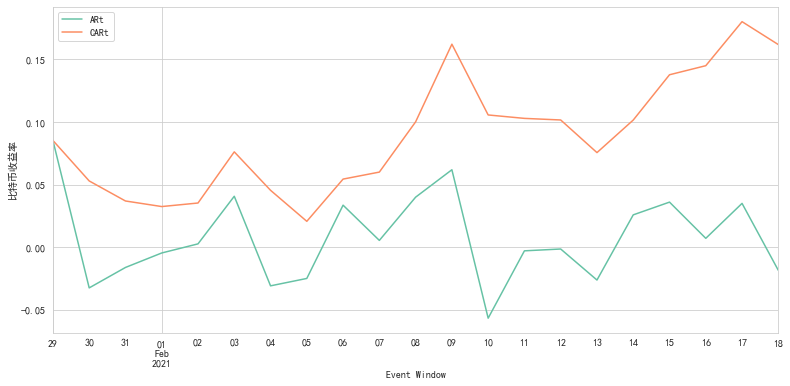

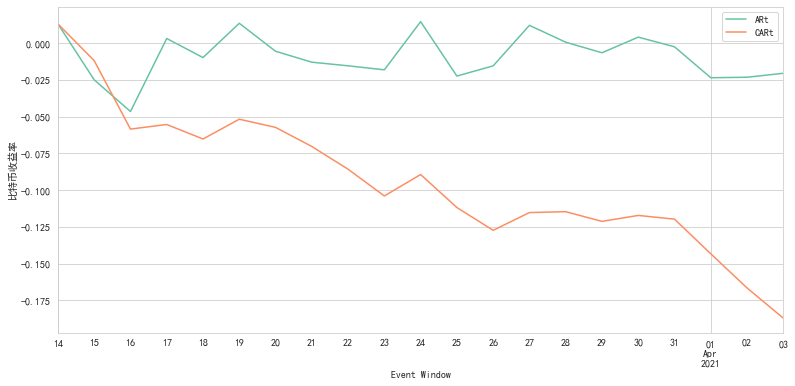

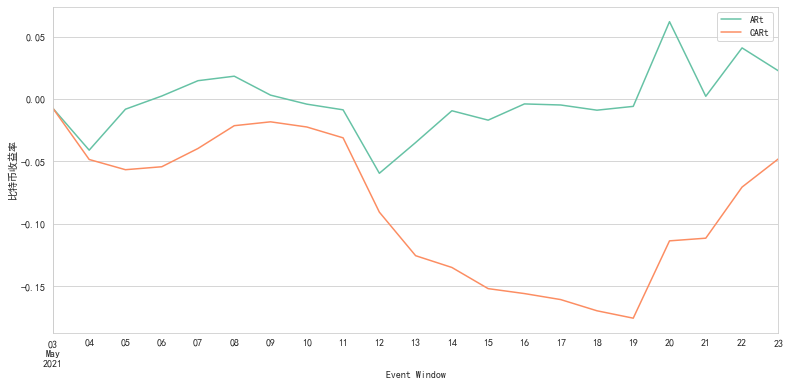

In [211]:
list(map(main, events))

In [ ]:
df.to_excel('excel_output.xls')

In [208]:
a

,trade_date,比特币收益率,数字货币市场收益率,E(Rt),ARt,CARt
109,2021-03-21,-0.029794,-0.028005,-0.022730,-0.007064,-0.007064
110,2021-03-22,-0.017702,-0.007831,-0.006306,-0.011396,-0.018461
111,2021-03-23,-0.029735,-0.020724,-0.016803,-0.012932,-0.031392
112,2021-03-24,0.002925,-0.020860,-0.016913,0.019838,-0.011555
113,2021-03-25,-0.051667,-0.045239,-0.036760,-0.014907,-0.026461
114,2021-03-26,0.023400,0.049181,0.040108,-0.016708,-0.043169
115,2021-03-27,0.037645,0.030719,0.025078,0.012567,-0.030601


In [202]:
a.to_excel('excel_output.xls')

# 进行T检验

In [18]:
!pip install scipy numpy
from scipy import stats

In [19]:
stats.ttest_1samp(a['ARt'],0)

Ttest_1sampResult(statistic=-0.36762428101372113, pvalue=0.7170150563073734)

In [20]:
a['ARt']

152   -0.012876
153   -0.026823
154   -0.012969
155   -0.008621
156    0.005610
157    0.004555
158   -0.000488
159   -0.003011
160   -0.009436
161   -0.043705
162   -0.011904
163   -0.024133
164   -0.012422
165    0.000538
166    0.003227
167   -0.011857
168    0.036648
169    0.029883
170    0.002481
171    0.033469
172    0.027549
Name: ARt, dtype: float64